In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Caltech101(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(texts_list):
    with torch.no_grad():
        label_ids = []
        text_features_cuda = []
        cls_features_cuda = []
        for label_id, texts in texts_list.items():
            label_ids.append([label_id] * len(texts))
            class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            text_features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        text_features = torch.vstack(text_features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, text_features, text_features_cuda, cls_features_cuda, masked_similarity

In [10]:
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create template text features
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(template_label_texts_list)

In [11]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/cal_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [12]:
# Mapping between CuPL and cls_name
special_class_mapping = {
    'centered face': 'face',
    'side of a car': 'car_side',
    'body of a cougar cat': 'cougar_body',
    'face of a cougar cat': 'cougar_face',
    'head of a crocodile': 'crocodile_head',
    'head of a flamingo': 'flamingo_head',
    'snoopy (cartoon beagle)': 'snoopy',
    'yin and yang symbol': 'yin_yang',
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
    'motorbike': ['motorcycle'],
    'airplane': ['aeroplane', 'plane'],
    'ferry': ['ferryboat', 'boat'],
    'rhino': ['rhinoceros'],
    'scissors': ['scissor'],
    'flamingo': ['flamingos'],
    'garfield': ['cat'],
    'body of a cougar cat': ['cougar'],
    'face of a cougar cat': ['cougar'],
}

In [13]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 2 prompts for (46)hawksbill
[' turtleI see a large, brown turtle with a long neck and a pointy beak.', ' turtleHawksbill turtles are a species of turtle found in tropical and subtropical waters around the globe.']

Filtered 3 prompts for (6)ant
['arctic glacierThe photo shows a large glacier in the Antarctic with a backdrop of mountains.', 'arctic expeditionThe photo is of a group of people in bulky coats and hats, standing on a sea of ice.', 'A small, hard-bodied creature with six legs and a pair of long, antennae.']

Filtered 1 prompts for (22)chandelier
['I am not sure what you are asking.']

Filtered 5 prompts for (36)emu
['The photo is of a large, flightless bird with long legs and a long neck.', 'The photo is of a large, flightless bird with long legs and neck.', 'The photo is of a large, flightless bird with long legs.', 'A large, flightless bird with long legs, a long neck, and a small head.', 'TheEmu is a large, flightless bird native to Australia.']

Filtered 1 promp

In [14]:
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create original gpt3 text features
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(filtered_gpt3_label_texts_list)

In [15]:
from collections import defaultdict

imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)

In [16]:
# Create image features
with torch.no_grad():
    img_label_ids = []
    img_features_cuda = []
    img_cls_features_cuda = []
    img_cls_name_similarity_cuda = []
    img_template_cls_similarity_cuda = []
    img_template_text_similarity_cuda = []
    img_original_gpt3_cls_similarity_cuda = []
    img_original_gpt3_text_similarity_cuda = []
    img_filtered_gpt3_cls_similarity_cuda = []
    img_filtered_gpt3_text_similarity_cuda = []
    for label_id, imgs in tqdm(imgs_grouped.items()):
        img_label_ids.append([label_id] * len(imgs))
        imgs = torch.stack([preprocess(img) for img in imgs]).to(device)
        img_embeddings = model.encode_image(imgs)
        img_embeddings /= img_embeddings.norm(dim=-1, keepdim=True)
        img_embedding = img_embeddings.mean(dim=0)
        img_embedding /= img_embedding.norm()
        img_features_cuda.append(img_embeddings)
        img_cls_features_cuda.append(img_embedding)
        # mean by cls then mul
        img_cls_name_similarity_cuda.append((img_embeddings @ cls_name_features_cuda.T).mean(dim=0))
        img_template_cls_similarity_cuda.append((img_embeddings @ template_cls_features_cuda.T).mean(dim=0))
        img_original_gpt3_cls_similarity_cuda.append((img_embeddings @ original_gpt3_cls_features_cuda.T).mean(dim=0))
        img_filtered_gpt3_cls_similarity_cuda.append((img_embeddings @ filtered_gpt3_cls_features_cuda.T).mean(dim=0))
        # mul then mean by cls
        img_template_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in template_text_features_cuda]))
        img_original_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in original_gpt3_text_features_cuda]))
        img_filtered_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in filtered_gpt3_text_features_cuda]))
    img_label_ids = np.hstack(img_label_ids)
    img_features_cuda = torch.vstack(img_features_cuda)
    img_features = img_features_cuda.cpu().numpy()
    img_cls_features_cuda = torch.vstack(img_cls_features_cuda)
    # mean by cls then mul
    img_cls_name_similarity = torch.vstack(img_cls_name_similarity_cuda).cpu().numpy()
    img_template_cls_similarity = torch.vstack(img_template_cls_similarity_cuda).cpu().numpy()
    img_original_gpt3_cls_similarity = torch.vstack(img_original_gpt3_cls_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_cls_similarity = torch.vstack(img_filtered_gpt3_cls_similarity_cuda).cpu().numpy()
    # mul then mean by cls
    img_template_text_similarity = torch.vstack(img_template_text_similarity_cuda).cpu().numpy()
    img_original_gpt3_text_similarity = torch.vstack(img_original_gpt3_text_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_text_similarity = torch.vstack(img_filtered_gpt3_text_similarity_cuda).cpu().numpy()

    # Fill diagonal for better visibility
    img_masked_similarity = (img_cls_features_cuda @ img_cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


In [17]:
# Zero-shot classification using CLIP
with torch.no_grad():
    logits_cls_name_cuda = img_features_cuda @ cls_name_features_cuda.T
    logits_template_cls_cuda = img_features_cuda @ template_cls_features_cuda.T
    logits_original_gpt3_cls_cuda = img_features_cuda @ original_gpt3_cls_features_cuda.T
    logits_filtered_gpt3_cls_cuda = img_features_cuda @ filtered_gpt3_cls_features_cuda.T

    pred_cls_name = logits_cls_name_cuda.argmax(dim=-1).cpu().numpy()
    pred_template_cls = logits_template_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_original_gpt3_cls = logits_original_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_filtered_gpt3_cls = logits_filtered_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()

    correct_cls_name = (pred_cls_name == img_label_ids).mean()
    correct_template_cls = (pred_template_cls == img_label_ids).mean()
    correct_original_gpt3 = (pred_original_gpt3_cls == img_label_ids).mean()
    correct_filtered_gpt3 = (pred_filtered_gpt3_cls == img_label_ids).mean()

In [18]:
print(f'Accuracy of CLIP with class names: {correct_cls_name*100:.2f}%')
print(f'Accuracy of CLIP with text template: {correct_template_cls*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text: {correct_original_gpt3*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text: {correct_filtered_gpt3*100:.2f}%')

Accuracy of CLIP with class names: 87.14%
Accuracy of CLIP with text template: 93.10%
Accuracy of CLIP with original GPT-3 text: 94.28%
Accuracy of CLIP with filtered GPT-3 text: 94.36%


In [19]:
def print_top_similarity(similarity, top=10):
    # Get the indices of top similarity values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top similarities
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, Similarity: {similarity[label1, label2]}')

In [20]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [21]:
def visualize_auto_similarity(masked_similarity, title):
    print(f'{title.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_similarity(np.triu(masked_similarity, k=1))
    plot_similarity(masked_similarity, title)

In [22]:
def visualize_cross_similarity(similarity, title, xlabel='Text', ylabel='Image'):
    print(f'{title.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_similarity(similarity, top=20)
    plot_similarity(similarity, title, xlabel=xlabel, ylabel=ylabel)

Class name similarity mean: 0.69970703125
Class name similarity std: 0.07928466796875
Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.94677734375
Rank 2: (23)cougar_body - (24)cougar_face, Similarity: 0.923828125
Rank 3: (40)flamingo - (41)flamingo_head, Similarity: 0.90966796875
Rank 4: (25)crab - (26)crayfish, Similarity: 0.8984375
Rank 5: (0)face - (12)brain, Similarity: 0.89208984375
Rank 6: (21)chair - (95)wheelchair, Similarity: 0.89013671875
Rank 7: (0)face - (24)cougar_face, Similarity: 0.89013671875
Rank 8: (25)crab - (58)lobster, Similarity: 0.8837890625
Rank 9: (15)butterfly - (33)dragonfly, Similarity: 0.8818359375
Rank 10: (26)crayfish - (58)lobster, Similarity: 0.8798828125


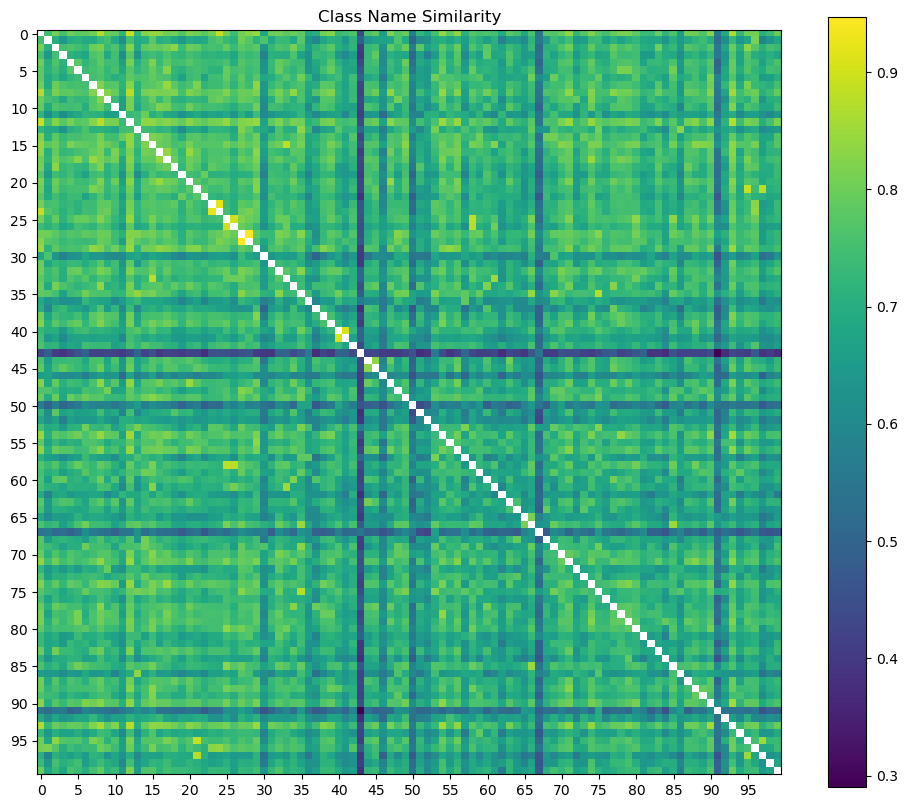

Text template similarity mean: 0.69482421875
Text template similarity std: 0.08038330078125
Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.955078125
Rank 2: (40)flamingo - (41)flamingo_head, Similarity: 0.9287109375
Rank 3: (23)cougar_body - (24)cougar_face, Similarity: 0.91748046875
Rank 4: (26)crayfish - (58)lobster, Similarity: 0.89990234375
Rank 5: (25)crab - (26)crayfish, Similarity: 0.89453125
Rank 6: (25)crab - (58)lobster, Similarity: 0.89453125
Rank 7: (16)camera - (20)cellphone, Similarity: 0.890625
Rank 8: (4)airplane - (49)helicopter, Similarity: 0.890625
Rank 9: (21)chair - (95)wheelchair, Similarity: 0.888671875
Rank 10: (0)face - (12)brain, Similarity: 0.88818359375


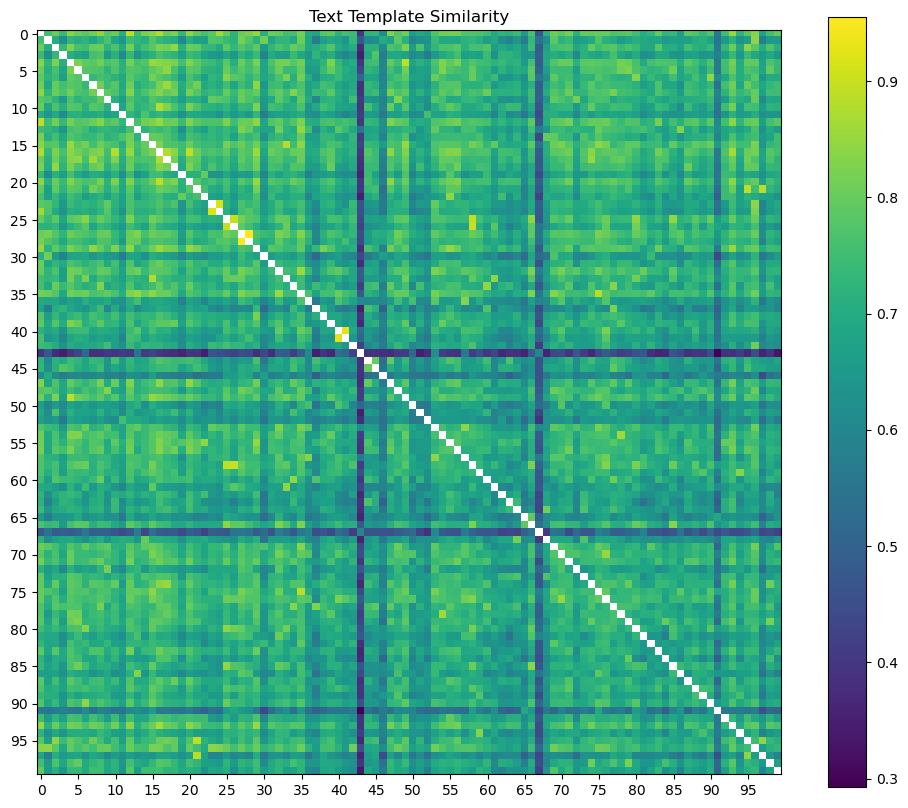

Original gpt-3 text similarity mean: 0.6708984375
Original gpt-3 text similarity std: 0.088134765625
Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, Similarity: 0.96142578125
Rank 3: (40)flamingo - (41)flamingo_head, Similarity: 0.9169921875
Rank 4: (54)ketch - (78)schooner, Similarity: 0.9150390625
Rank 5: (26)crayfish - (58)lobster, Similarity: 0.9111328125
Rank 6: (23)cougar_body - (96)wild_cat, Similarity: 0.908203125
Rank 7: (25)crab - (58)lobster, Similarity: 0.90576171875
Rank 8: (24)cougar_face - (96)wild_cat, Similarity: 0.89990234375
Rank 9: (59)lotus - (94)water_lilly, Similarity: 0.8984375
Rank 10: (35)elephant - (75)rhino, Similarity: 0.89794921875


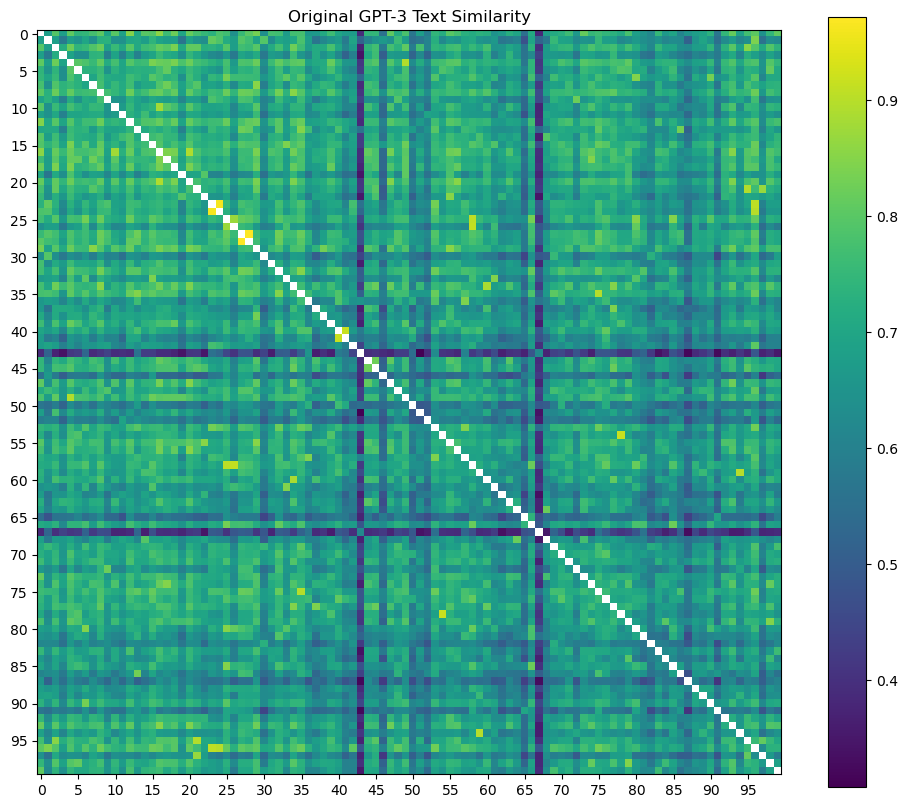

Filtered gpt-3 text similarity mean: 0.66650390625
Filtered gpt-3 text similarity std: 0.088623046875
Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.970703125
Rank 2: (23)cougar_body - (24)cougar_face, Similarity: 0.96142578125
Rank 3: (40)flamingo - (41)flamingo_head, Similarity: 0.91650390625
Rank 4: (54)ketch - (78)schooner, Similarity: 0.9111328125
Rank 5: (26)crayfish - (58)lobster, Similarity: 0.9111328125
Rank 6: (23)cougar_body - (96)wild_cat, Similarity: 0.908203125
Rank 7: (25)crab - (58)lobster, Similarity: 0.90576171875
Rank 8: (24)cougar_face - (96)wild_cat, Similarity: 0.900390625
Rank 9: (59)lotus - (94)water_lilly, Similarity: 0.8984375
Rank 10: (4)airplane - (49)helicopter, Similarity: 0.89453125


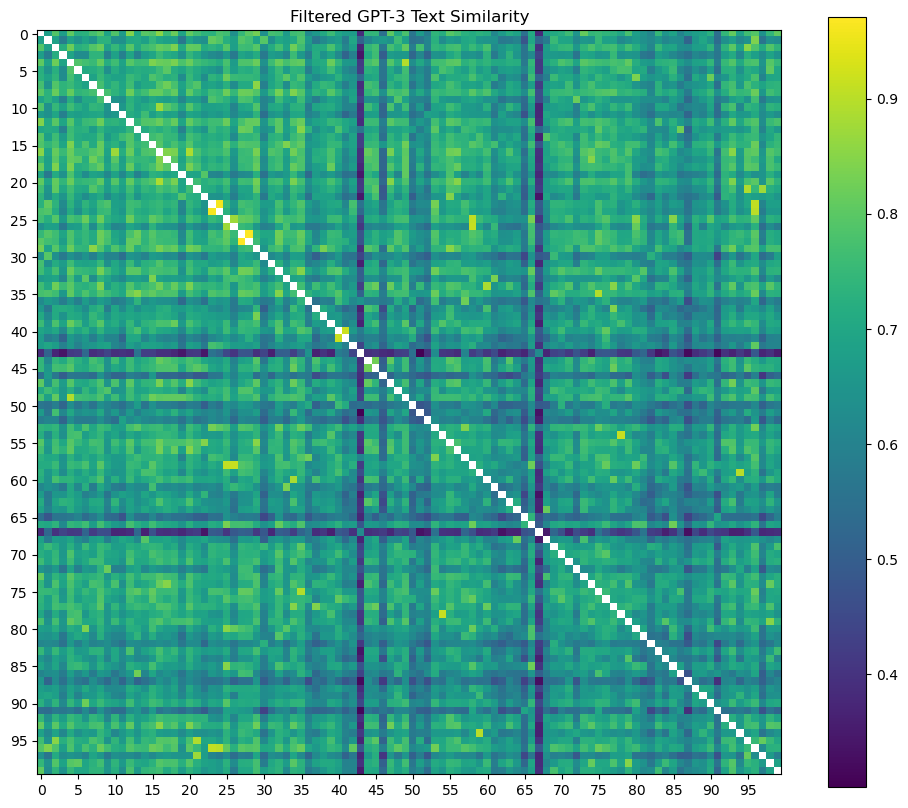

In [23]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name Similarity')
visualize_auto_similarity(template_masked_similarity, 'Text Template Similarity')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text Similarity')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text Similarity')

Image similarity mean: 0.7080078125
Image similarity std: 0.06591796875
Rank 1: (59)lotus - (94)water_lilly, Similarity: 0.9833984375
Rank 2: (54)ketch - (78)schooner, Similarity: 0.97509765625
Rank 3: (27)crocodile - (28)crocodile_head, Similarity: 0.96826171875
Rank 4: (21)chair - (97)windsor_chair, Similarity: 0.96630859375
Rank 5: (26)crayfish - (58)lobster, Similarity: 0.96240234375
Rank 6: (23)cougar_body - (24)cougar_face, Similarity: 0.96044921875
Rank 7: (40)flamingo - (41)flamingo_head, Similarity: 0.95751953125
Rank 8: (26)crayfish - (80)scorpion, Similarity: 0.95556640625
Rank 9: (25)crab - (26)crayfish, Similarity: 0.94873046875
Rank 10: (33)dragonfly - (61)mayfly, Similarity: 0.94873046875


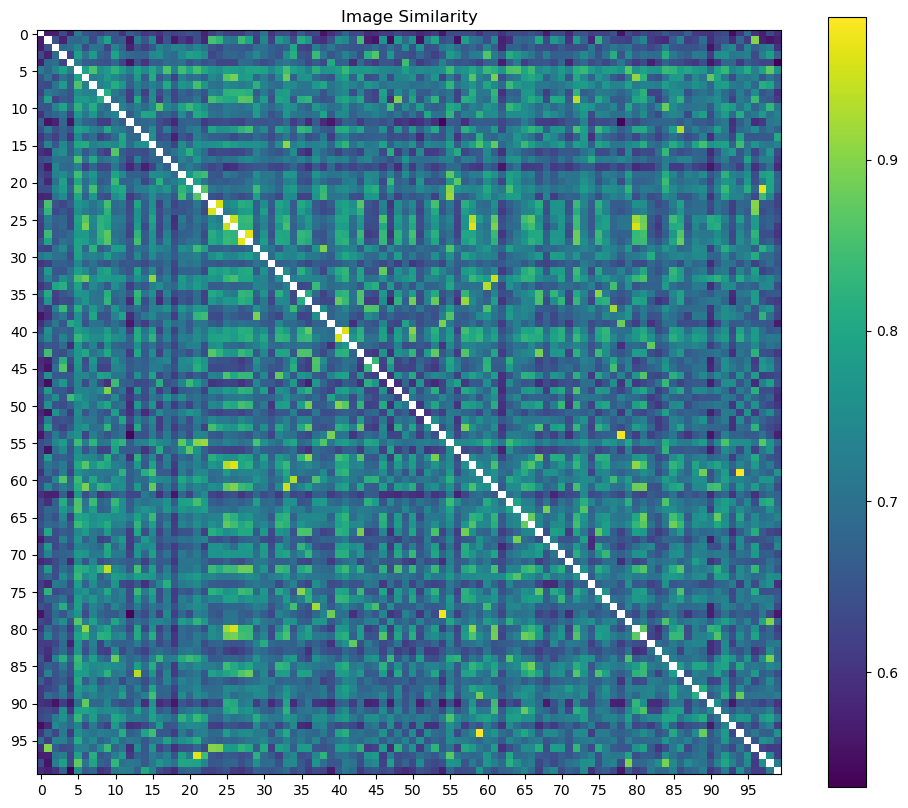

Image to class name similarity mean: 0.1925048828125
Image to class name similarity std: 0.0236358642578125
Image to class name similarity diagonal mean: 0.298583984375
Image to class name similarity diagonal std: 0.0182037353515625
Image to class name similarity non-diagonal mean: 0.19140625
Image to class name similarity non-diagonal std: 0.0211029052734375
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.5595703125
Rank 1: (52)joshua_tree - (52)joshua_tree, Similarity: 0.33740234375
Rank 2: (67)okapi - (67)okapi, Similarity: 0.334228515625
Rank 3: (62)menorah - (62)menorah, Similarity: 0.33349609375
Rank 4: (44)gramophone - (44)gramophone, Similarity: 0.33056640625
Rank 5: (36)emu - (36)emu, Similarity: 0.330322265625
Rank 6: (19)ceiling_fan - (19)ceiling_fan, Similarity: 0.328857421875
Rank 7: (63)metronome - (63)metronome, Similarity: 0.324951171875
Rank 8: (7)barrel - (7)barrel, Similarity: 0.3232421875
Rank 9: (99)yin_yang - (99)yin_yang, Similarity: 0.

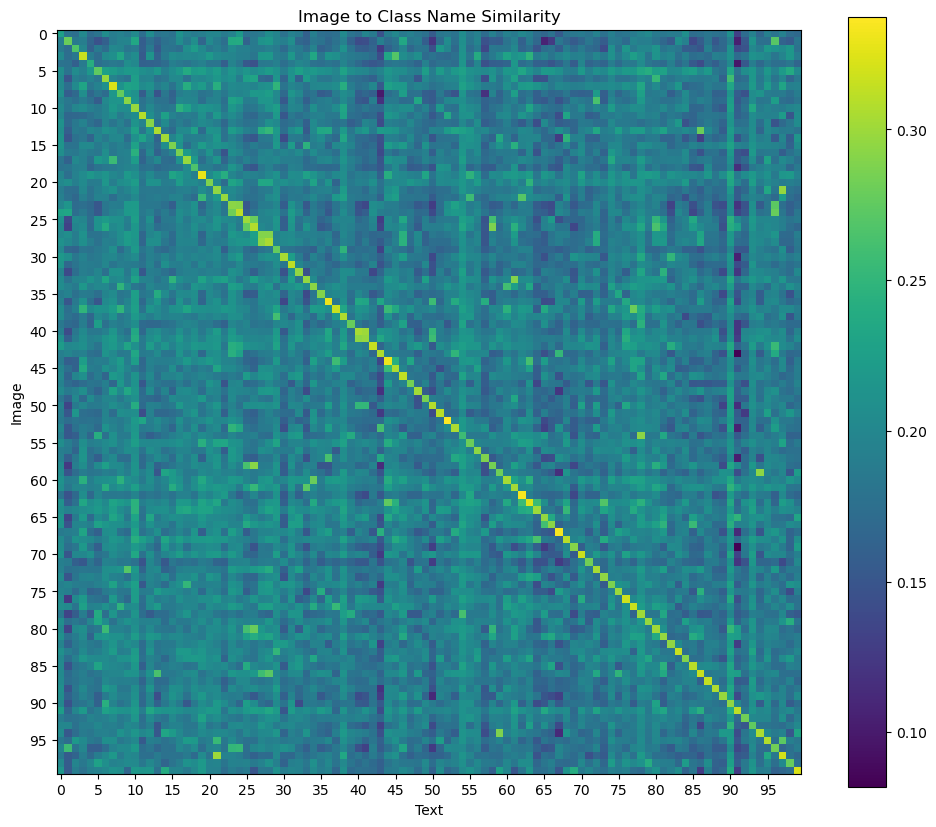

Image to text template similarity mean: 0.1964111328125
Image to text template similarity std: 0.0265045166015625
Image to text template similarity diagonal mean: 0.322998046875
Image to text template similarity diagonal std: 0.018768310546875
Image to text template similarity non-diagonal mean: 0.1951904296875
Image to text template similarity non-diagonal std: 0.0233001708984375
Image to text template similarity diagonal mean to non-diagonal mean ratio: 1.654296875
Rank 1: (63)metronome - (63)metronome, Similarity: 0.3681640625
Rank 2: (67)okapi - (67)okapi, Similarity: 0.364013671875
Rank 3: (52)joshua_tree - (52)joshua_tree, Similarity: 0.35595703125
Rank 4: (36)emu - (36)emu, Similarity: 0.3544921875
Rank 5: (19)ceiling_fan - (19)ceiling_fan, Similarity: 0.349609375
Rank 6: (62)menorah - (62)menorah, Similarity: 0.343505859375
Rank 7: (51)inline_skate - (51)inline_skate, Similarity: 0.342041015625
Rank 8: (85)starfish - (85)starfish, Similarity: 0.342041015625
Rank 9: (7)barrel - 

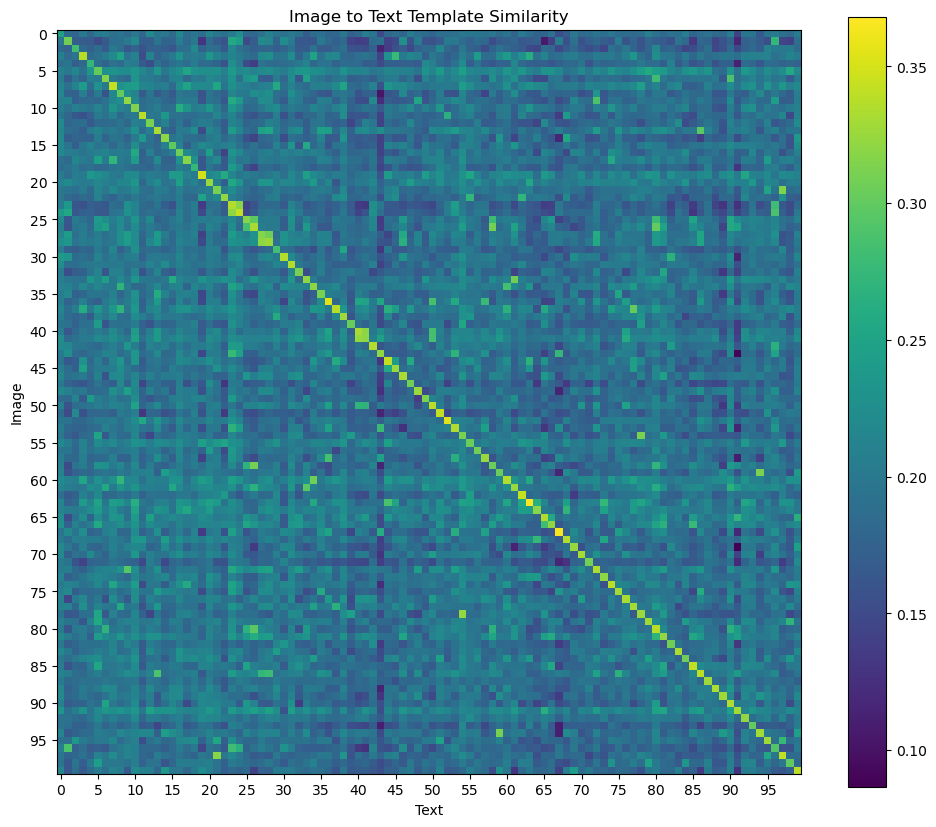

Image to text template similarity (individual) mean: 0.17965322732925415
Image to text template similarity (individual) std: 0.024276724085211754
Image to text template similarity (individual) diagonal mean: 0.29536986351013184
Image to text template similarity (individual) diagonal std: 0.01737390272319317
Image to text template similarity (individual) non-diagonal mean: 0.17848435044288635
Image to text template similarity (individual) non-diagonal std: 0.021345753222703934
Image to text template similarity (individual) diagonal mean to non-diagonal mean ratio: 1.6548782587051392
Rank 1: (63)metronome - (63)metronome, Similarity: 0.337646484375
Rank 2: (67)okapi - (67)okapi, Similarity: 0.333740234375
Rank 3: (52)joshua_tree - (52)joshua_tree, Similarity: 0.3251953125
Rank 4: (19)ceiling_fan - (19)ceiling_fan, Similarity: 0.324462890625
Rank 5: (36)emu - (36)emu, Similarity: 0.3212890625
Rank 6: (99)yin_yang - (99)yin_yang, Similarity: 0.31640625
Rank 7: (44)gramophone - (44)gramopho

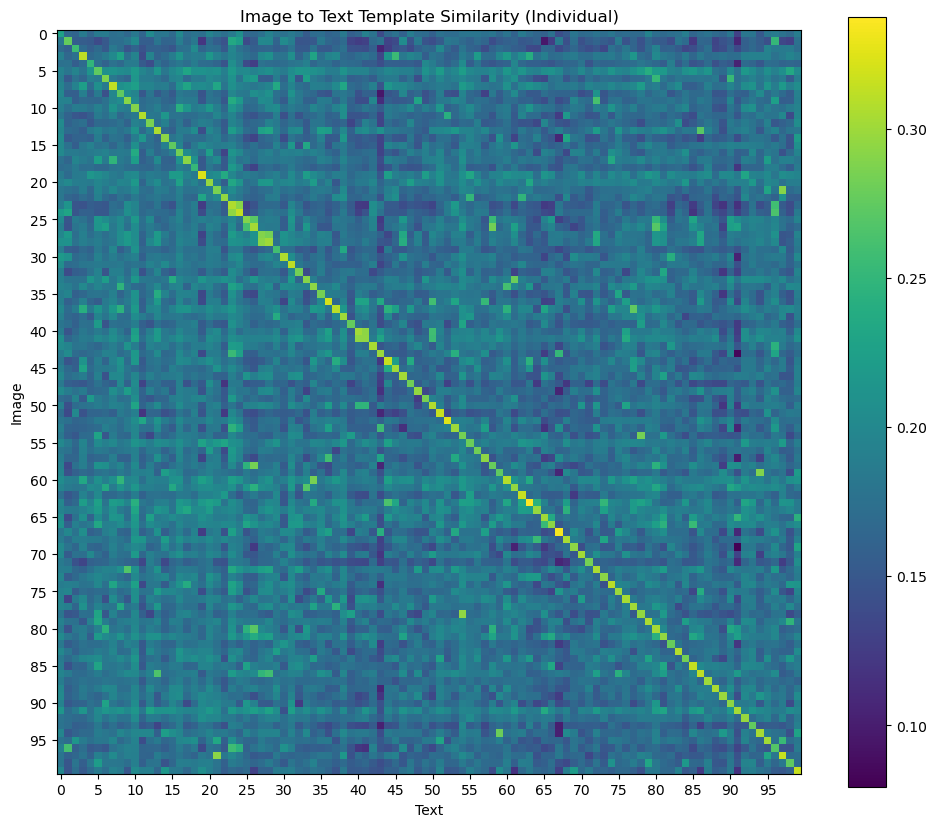

Image to original gpt-3 text similarity mean: 0.195556640625
Image to original gpt-3 text similarity std: 0.0283050537109375
Image to original gpt-3 text similarity diagonal mean: 0.333251953125
Image to original gpt-3 text similarity diagonal std: 0.0185546875
Image to original gpt-3 text similarity non-diagonal mean: 0.1942138671875
Image to original gpt-3 text similarity non-diagonal std: 0.0247650146484375
Image to original gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.7158203125
Rank 1: (52)joshua_tree - (52)joshua_tree, Similarity: 0.377685546875
Rank 2: (63)metronome - (63)metronome, Similarity: 0.365966796875
Rank 3: (67)okapi - (67)okapi, Similarity: 0.36474609375
Rank 4: (19)ceiling_fan - (19)ceiling_fan, Similarity: 0.364501953125
Rank 5: (87)stop_sign - (87)stop_sign, Similarity: 0.36083984375
Rank 6: (36)emu - (36)emu, Similarity: 0.357666015625
Rank 7: (7)barrel - (7)barrel, Similarity: 0.357177734375
Rank 8: (80)scorpion - (80)scorpion, Similarity: 0.

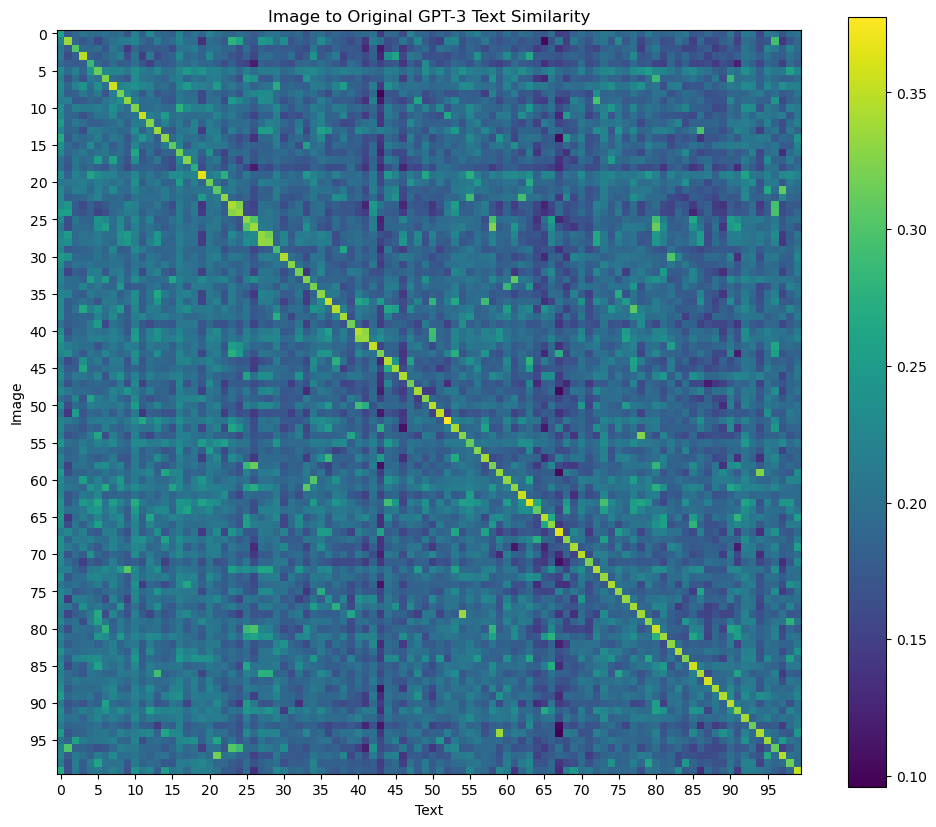

Image to original gpt-3 text similarity (individual) mean: 0.18378494679927826
Image to original gpt-3 text similarity (individual) std: 0.026468710973858833
Image to original gpt-3 text similarity (individual) diagonal mean: 0.3132971227169037
Image to original gpt-3 text similarity (individual) diagonal std: 0.019151650369167328
Image to original gpt-3 text similarity (individual) non-diagonal mean: 0.18247675895690918
Image to original gpt-3 text similarity (individual) non-diagonal std: 0.023082999512553215
Image to original gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.716915249824524
Rank 1: (52)joshua_tree - (52)joshua_tree, Similarity: 0.34814453125
Rank 2: (19)ceiling_fan - (19)ceiling_fan, Similarity: 0.347900390625
Rank 3: (67)okapi - (67)okapi, Similarity: 0.34716796875
Rank 4: (63)metronome - (63)metronome, Similarity: 0.3447265625
Rank 5: (62)menorah - (62)menorah, Similarity: 0.342529296875
Rank 6: (99)yin_yang - (99)yin_yang, Similarity:

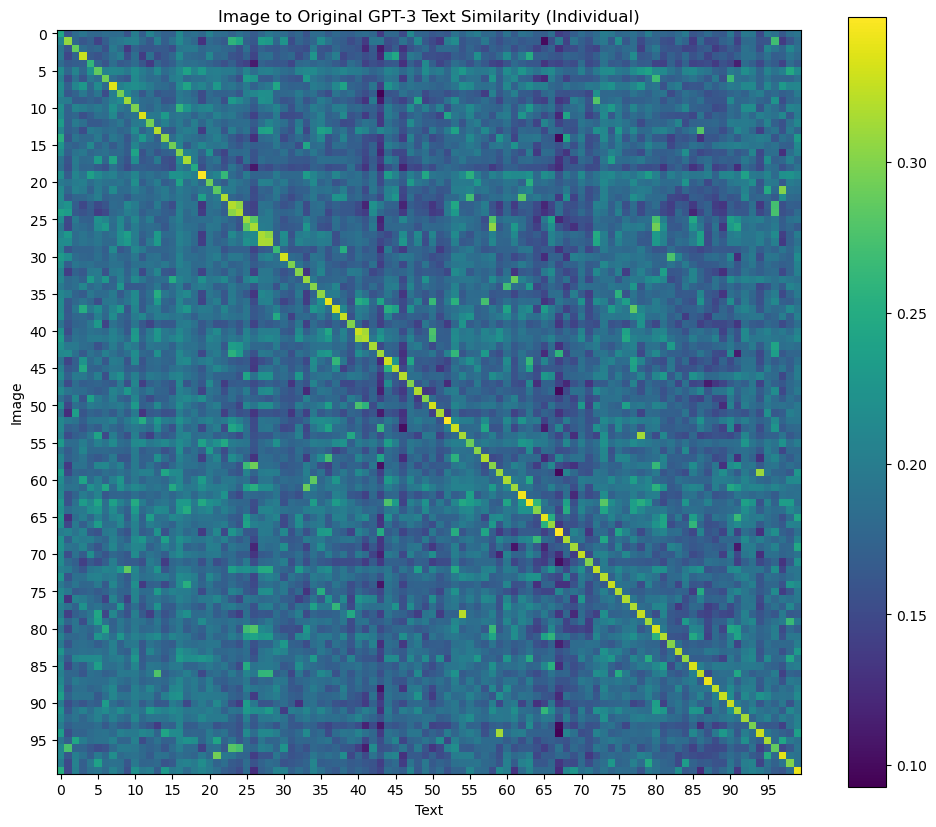

Image to filtered gpt-3 text similarity mean: 0.1949462890625
Image to filtered gpt-3 text similarity std: 0.0283966064453125
Image to filtered gpt-3 text similarity diagonal mean: 0.333251953125
Image to filtered gpt-3 text similarity diagonal std: 0.0184173583984375
Image to filtered gpt-3 text similarity non-diagonal mean: 0.1934814453125
Image to filtered gpt-3 text similarity non-diagonal std: 0.0248260498046875
Image to filtered gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.72265625
Rank 1: (52)joshua_tree - (52)joshua_tree, Similarity: 0.377685546875
Rank 2: (63)metronome - (63)metronome, Similarity: 0.36572265625
Rank 3: (67)okapi - (67)okapi, Similarity: 0.36474609375
Rank 4: (19)ceiling_fan - (19)ceiling_fan, Similarity: 0.364501953125
Rank 5: (87)stop_sign - (87)stop_sign, Similarity: 0.36083984375
Rank 6: (7)barrel - (7)barrel, Similarity: 0.357177734375
Rank 7: (80)scorpion - (80)scorpion, Similarity: 0.356201171875
Rank 8: (11)bonsai - (11)bonsai, Simi

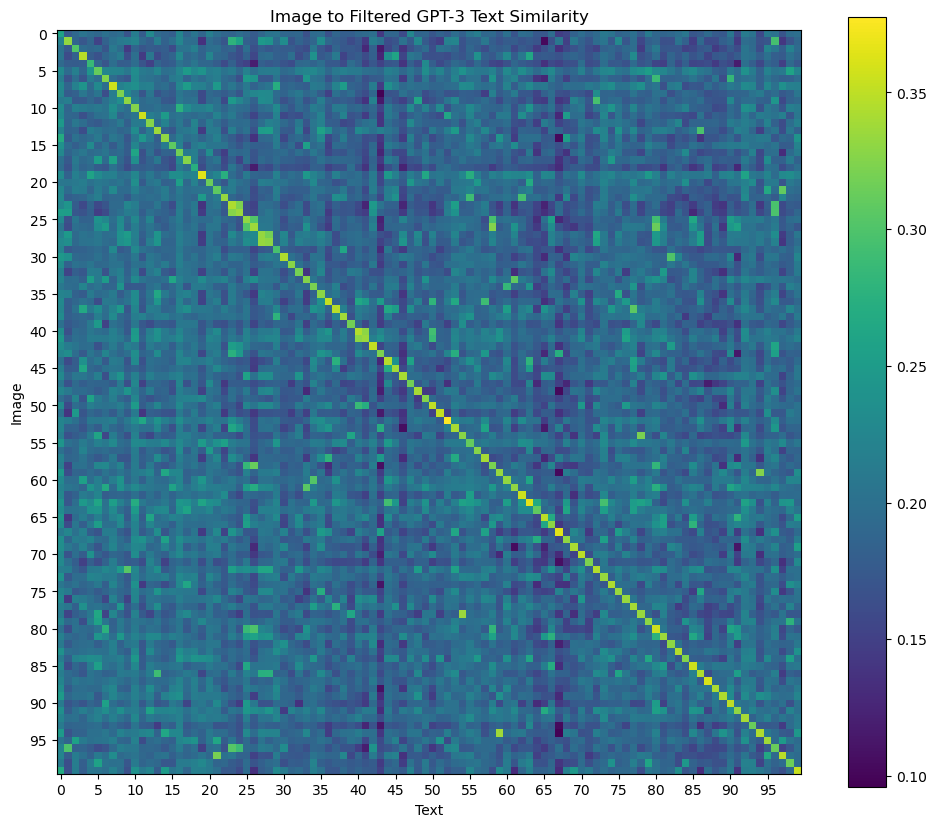

Image to filtered gpt-3 text similarity (individual) mean: 0.18379881978034973
Image to filtered gpt-3 text similarity (individual) std: 0.026653677225112915
Image to filtered gpt-3 text similarity (individual) diagonal mean: 0.3142407238483429
Image to filtered gpt-3 text similarity (individual) diagonal std: 0.018765009939670563
Image to filtered gpt-3 text similarity (individual) non-diagonal mean: 0.18248121440410614
Image to filtered gpt-3 text similarity (individual) non-diagonal std: 0.023247191682457924
Image to filtered gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.7220442295074463
Rank 1: (52)joshua_tree - (52)joshua_tree, Similarity: 0.34814453125
Rank 2: (19)ceiling_fan - (19)ceiling_fan, Similarity: 0.347900390625
Rank 3: (67)okapi - (67)okapi, Similarity: 0.34716796875
Rank 4: (63)metronome - (63)metronome, Similarity: 0.346923828125
Rank 5: (62)menorah - (62)menorah, Similarity: 0.342529296875
Rank 6: (99)yin_yang - (99)yin_yang, Similari

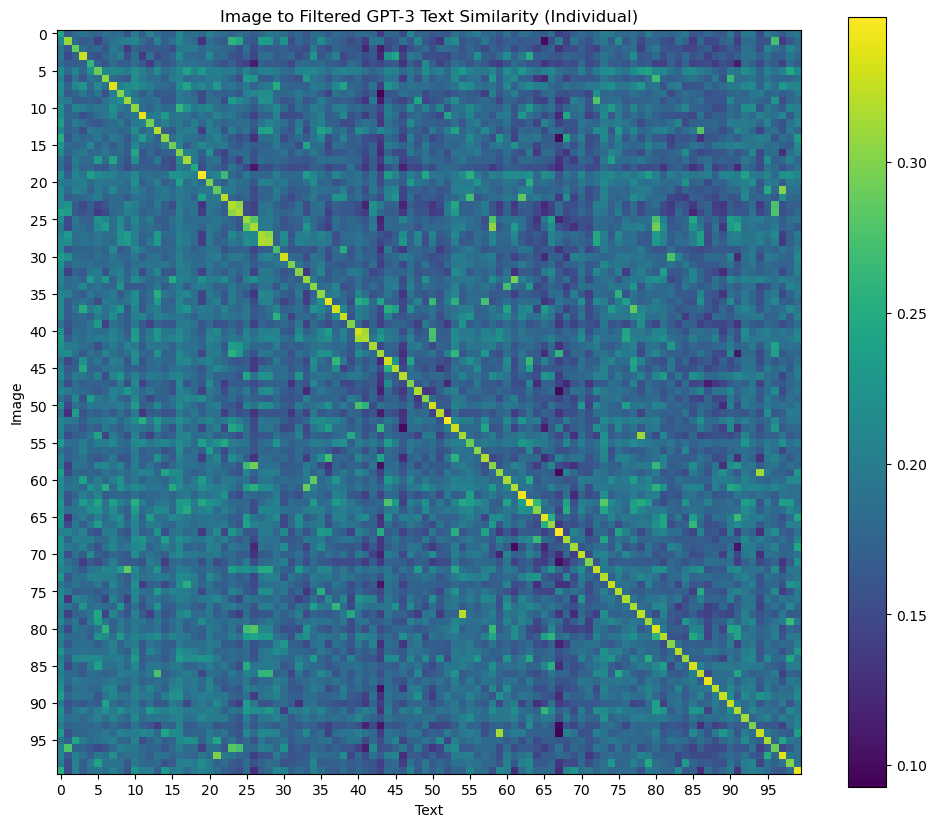

In [24]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image Similarity')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, 'Image to Class Name Similarity')
visualize_cross_similarity(img_template_cls_similarity, 'Image to Text Template Similarity')
visualize_cross_similarity(img_template_text_similarity, 'Image to Text Template Similarity (Individual)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, 'Image to Original GPT-3 Text Similarity')
visualize_cross_similarity(img_original_gpt3_text_similarity, 'Image to Original GPT-3 Text Similarity (Individual)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, 'Image to Filtered GPT-3 Text Similarity')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, 'Image to Filtered GPT-3 Text Similarity (Individual)')

In [25]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [26]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [27]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.94677734375
Rank 2: (23)cougar_body - (24)cougar_face, Similarity: 0.923828125
Rank 3: (40)flamingo - (41)flamingo_head, Similarity: 0.90966796875
Rank 4: (25)crab - (26)crayfish, Similarity: 0.8984375
Rank 5: (0)face - (12)brain, Similarity: 0.89208984375
Rank 6: (21)chair - (95)wheelchair, Similarity: 0.89013671875
Rank 7: (0)face - (24)cougar_face, Similarity: 0.89013671875
Rank 8: (25)crab - (58)lobster, Similarity: 0.8837890625
Rank 9: (15)butterfly - (33)dragonfly, Similarity: 0.8818359375
Rank 10: (26)crayfish - (58)lobster, Similarity: 0.8798828125


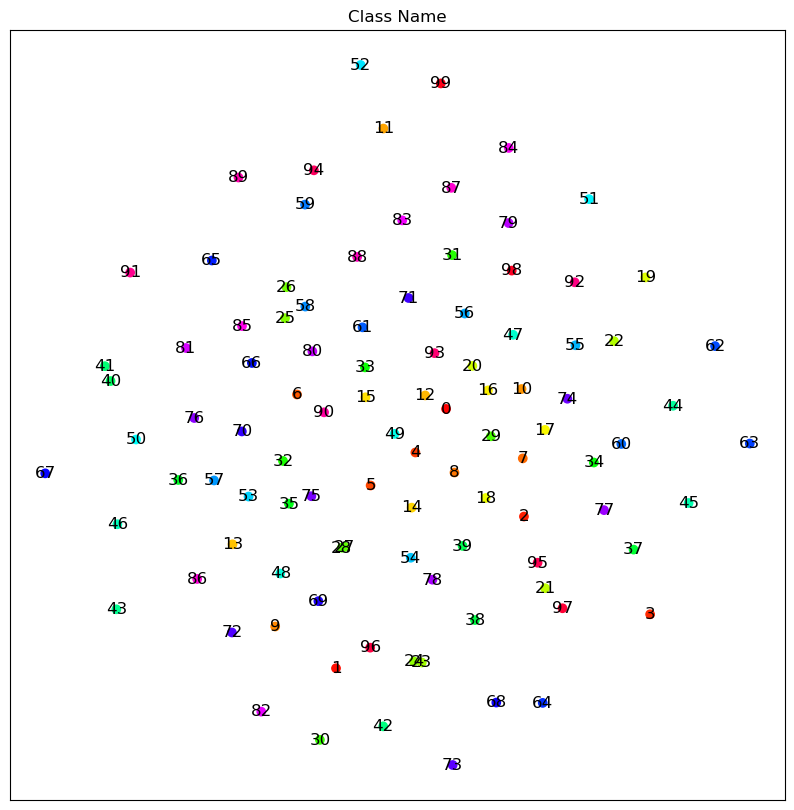

Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.955078125
Rank 2: (40)flamingo - (41)flamingo_head, Similarity: 0.9287109375
Rank 3: (23)cougar_body - (24)cougar_face, Similarity: 0.91748046875
Rank 4: (26)crayfish - (58)lobster, Similarity: 0.89990234375
Rank 5: (25)crab - (26)crayfish, Similarity: 0.89453125
Rank 6: (25)crab - (58)lobster, Similarity: 0.89453125
Rank 7: (16)camera - (20)cellphone, Similarity: 0.890625
Rank 8: (4)airplane - (49)helicopter, Similarity: 0.890625
Rank 9: (21)chair - (95)wheelchair, Similarity: 0.888671875
Rank 10: (0)face - (12)brain, Similarity: 0.88818359375


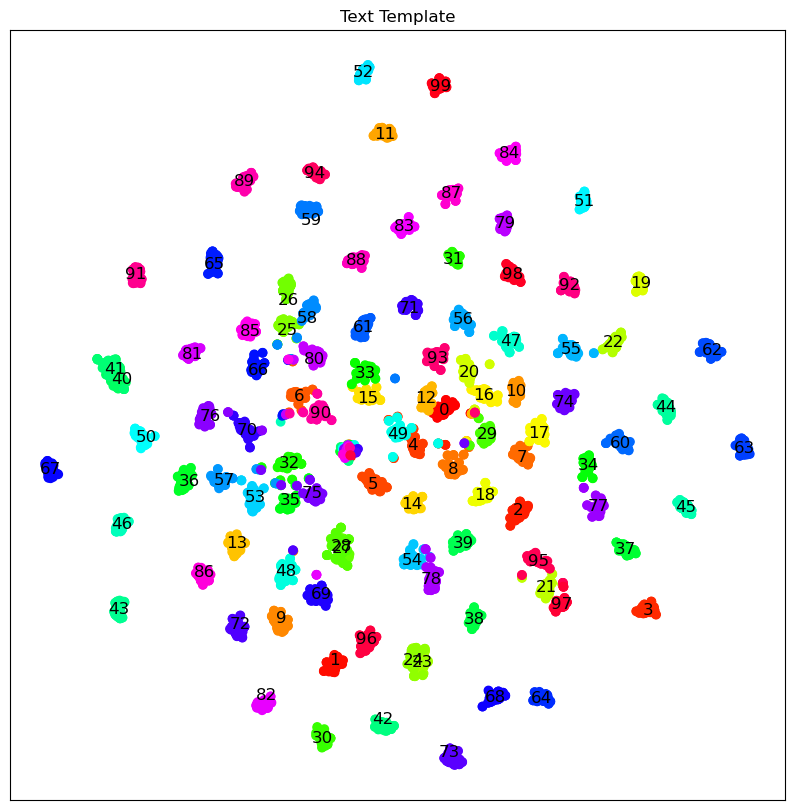

Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, Similarity: 0.96142578125
Rank 3: (40)flamingo - (41)flamingo_head, Similarity: 0.9169921875
Rank 4: (54)ketch - (78)schooner, Similarity: 0.9150390625
Rank 5: (26)crayfish - (58)lobster, Similarity: 0.9111328125
Rank 6: (23)cougar_body - (96)wild_cat, Similarity: 0.908203125
Rank 7: (25)crab - (58)lobster, Similarity: 0.90576171875
Rank 8: (24)cougar_face - (96)wild_cat, Similarity: 0.89990234375
Rank 9: (59)lotus - (94)water_lilly, Similarity: 0.8984375
Rank 10: (35)elephant - (75)rhino, Similarity: 0.89794921875


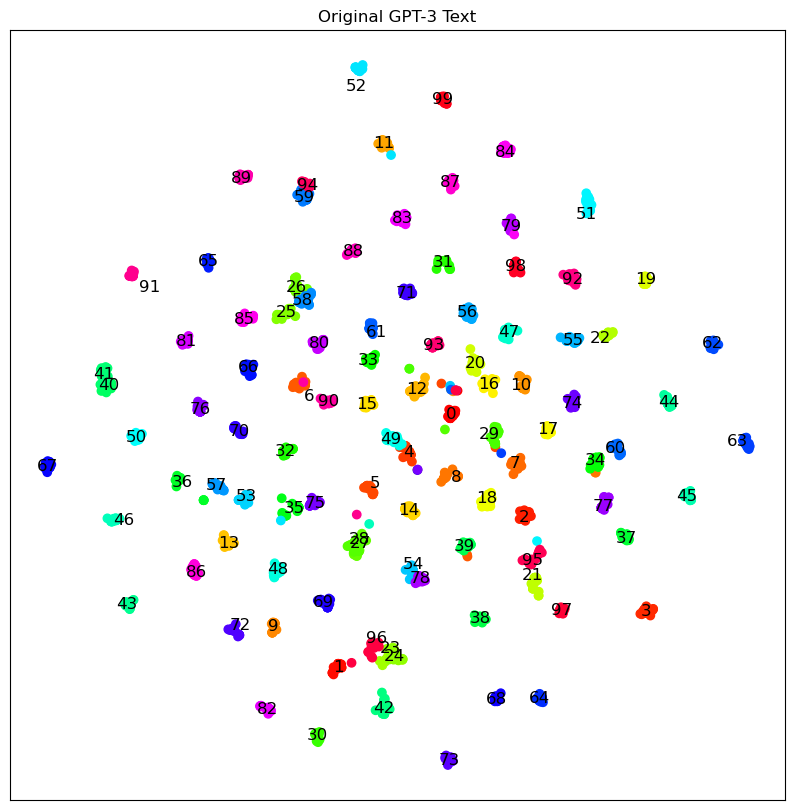

Rank 1: (27)crocodile - (28)crocodile_head, Similarity: 0.970703125
Rank 2: (23)cougar_body - (24)cougar_face, Similarity: 0.96142578125
Rank 3: (40)flamingo - (41)flamingo_head, Similarity: 0.91650390625
Rank 4: (54)ketch - (78)schooner, Similarity: 0.9111328125
Rank 5: (26)crayfish - (58)lobster, Similarity: 0.9111328125
Rank 6: (23)cougar_body - (96)wild_cat, Similarity: 0.908203125
Rank 7: (25)crab - (58)lobster, Similarity: 0.90576171875
Rank 8: (24)cougar_face - (96)wild_cat, Similarity: 0.900390625
Rank 9: (59)lotus - (94)water_lilly, Similarity: 0.8984375
Rank 10: (4)airplane - (49)helicopter, Similarity: 0.89453125


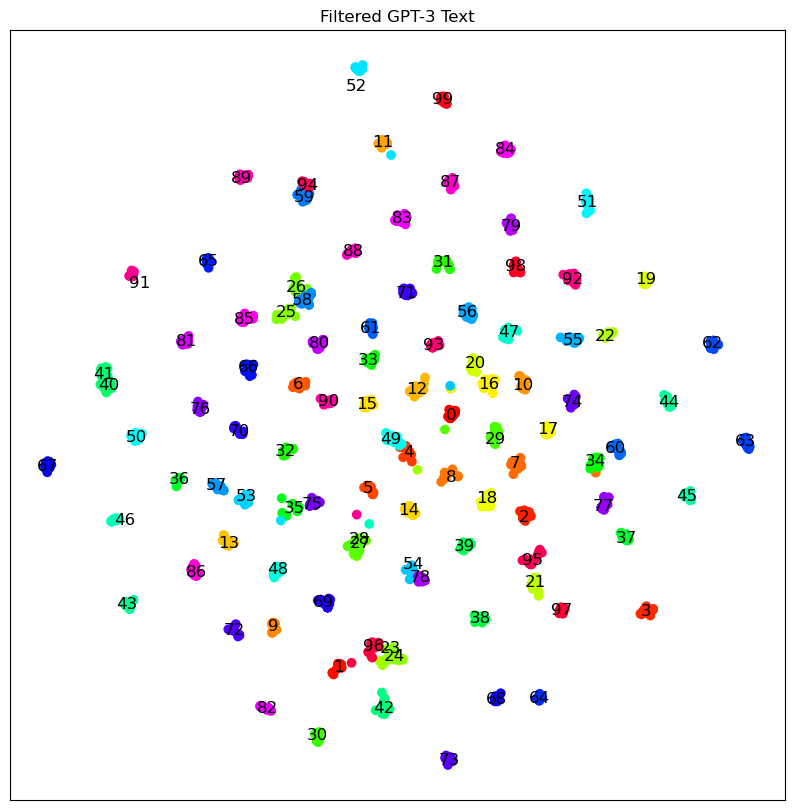

In [28]:
print_top_similarity(np.triu(cls_name_masked_similarity, k=1))
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_similarity(np.triu(template_masked_similarity, k=1))
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_similarity(np.triu(original_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_similarity(np.triu(filtered_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')